In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rashikrahmanpritom/plant-disease-recognition-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plant-disease-recognition-dataset' dataset.
Path to dataset files: /kaggle/input/plant-disease-recognition-dataset


In [10]:
import shutil

src = "/kaggle/input/plant-disease-recognition-dataset"
dst = "/content/"

# Move the entire folder
shutil.move(src, dst)


OSError: [Errno 30] Read-only file system: '/kaggle/input/plant-disease-recognition-dataset/Train/Train/Powdery'

# Import necessary libraries

In [12]:
# Block 1: Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set parameters
IMG_SIZE = 224  # MobileNetV2 input size
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 3
TRAIN_DIR = '/content/plant-disease-recognition-dataset/Train/Train'  # Update with your actual path
VALID_DIR = '/content/plant-disease-recognition-dataset/Validation/Validation'  # Update with your actual path
TEST_DIR = '/content/plant-disease-recognition-dataset/Test/Test'    # Update with your actual path

# Ensure directories exist (for verification)
print("Train dir classes:", os.listdir(TRAIN_DIR))
print("Valid dir classes:", os.listdir(VALID_DIR))
print("Test dir classes:", os.listdir(TEST_DIR))

Train dir classes: ['Rust', 'Powdery', 'Healthy']
Valid dir classes: ['Rust', 'Powdery', 'Healthy']
Test dir classes: ['Rust', 'Powdery', 'Healthy']


#Preprocess the data using ImageDataGenerator
for augmentation and rescaling

In [13]:
# Block 2: Preprocess the data using ImageDataGenerator for augmentation and rescaling
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling only for validation and test
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # For evaluation
)

# Get class names
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Class names: ['Healthy', 'Powdery', 'Rust']


Visualizing training data:


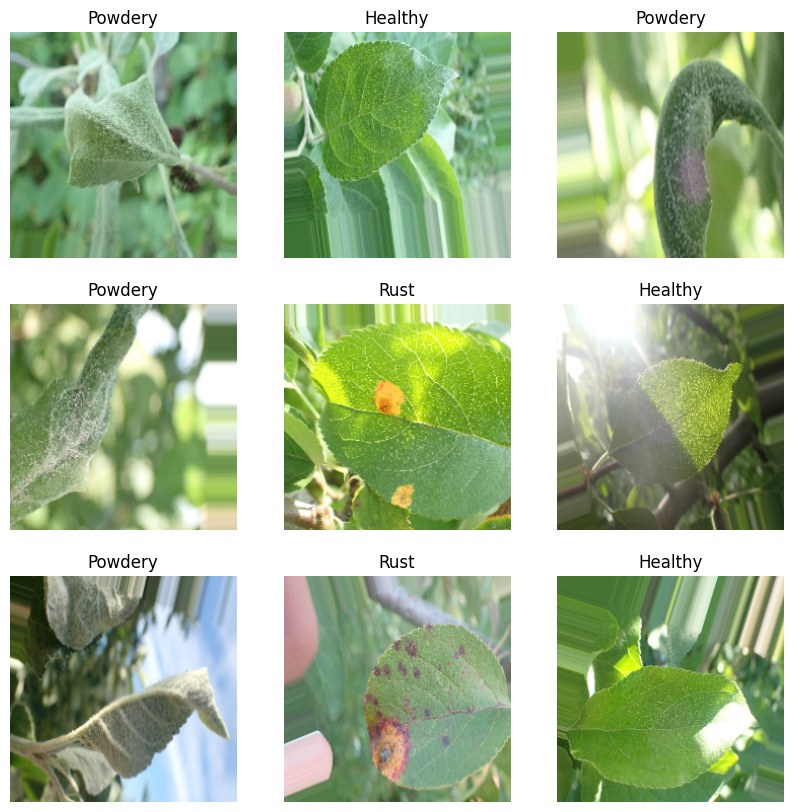

Visualizing validation data:


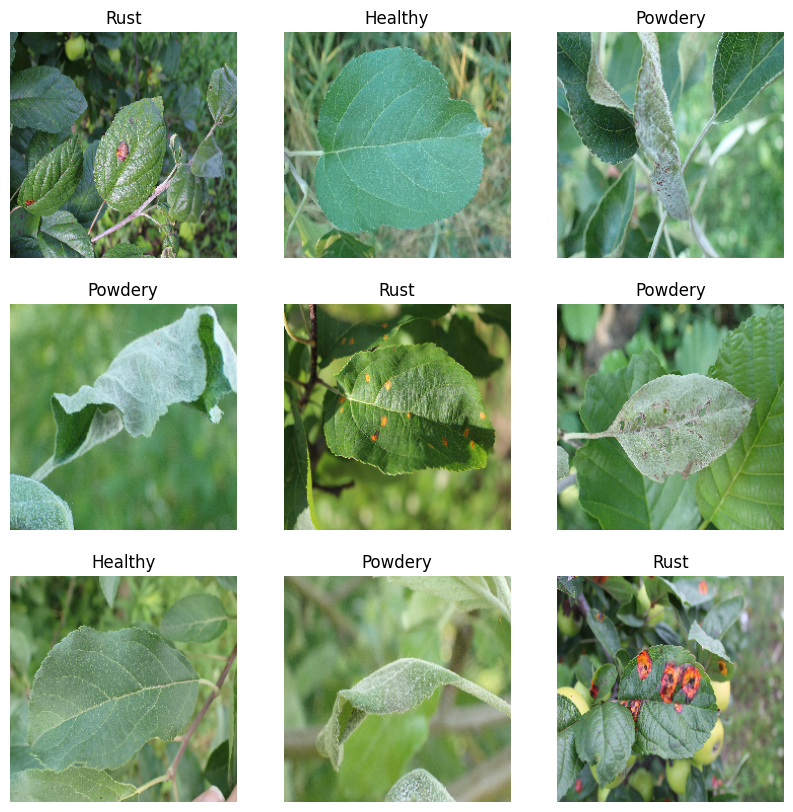

In [14]:
# Block 3: Visualize some training images
def plot_images(generator, class_names, num_images=9):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

# Visualize training data
print("Visualizing training data:")
plot_images(train_generator, class_names)

# Visualize validation data
print("Visualizing validation data:")
plot_images(valid_generator, class_names)

# Build and customize MobileNetV2 model

In [15]:
# Block 4: Build and customize MobileNetV2 model
# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model initially
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,915,395 (11.12 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Train the model (initial training with frozen base)

In [16]:
# Block 5: Train the model (initial training with frozen base)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=3,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Fine-tuning: Unfreeze some layers of the base model
base_model.trainable = True
fine_tune_at = 100  # Unfreeze from this layer onwards
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    epochs=5,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.6842 - loss: 0.7783 - val_accuracy: 0.9688 - val_loss: 0.1014 - learning_rate: 0.0010
Epoch 2/3
 1/41 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9688 - loss: 0.1646

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9688 - loss: 0.1646 - val_accuracy: 0.9062 - val_loss: 0.1914 - learning_rate: 0.0010
Epoch 3/3
41/41 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.9250 - loss: 0.2037 - val_accuracy: 1.0000 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.9149 - loss: 0.2583 - val_accuracy: 0.9688 - val_loss: 0.0551 - learning_rate: 1.0000e-04
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9688 - loss: 0.0511 - val_accuracy: 0.9688 - val_loss: 0.0546 - learning_rate: 1.0000e-04
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9762 - loss: 0.0711 - val_accuracy: 0.9688 - val_loss: 0.1442 - learning_rate: 1.0000e-04
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9688 - loss: 0.0648 - val_accuracy: 1.0000 - val_loss: 0.0067 - learning_rate: 1.0000e-04
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9823 - loss: 0.0476 - val_accura

# Evaluate the model on test data

In [21]:
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [22]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [23]:
class_names

['Healthy', 'Powdery', 'Rust']

5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.9763 - loss: 0.1768
Test Accuracy: 0.97
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
              precision    recall  f1-score   support

     Healthy       0.91      1.00      0.95        50
     Powdery       1.00      0.94      0.97        50
        Rust       1.00      0.96      0.98        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



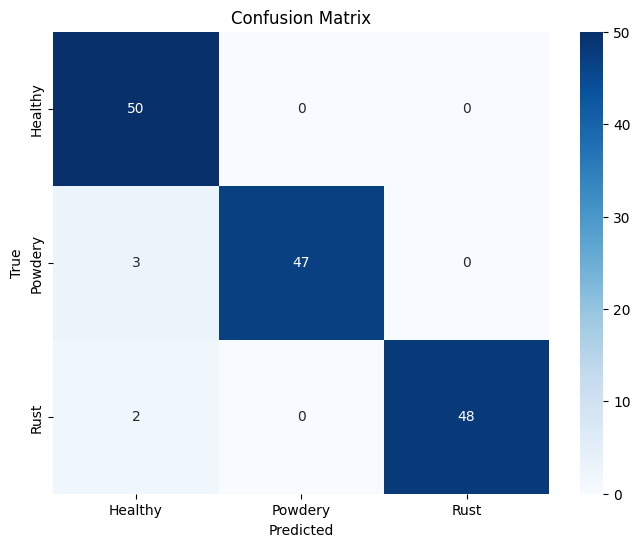

In [18]:
# Block 6: Evaluate the model on test data
# Load the best model
model.load_weights('best_model.keras')

# Evaluate
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# -> Visualize training results

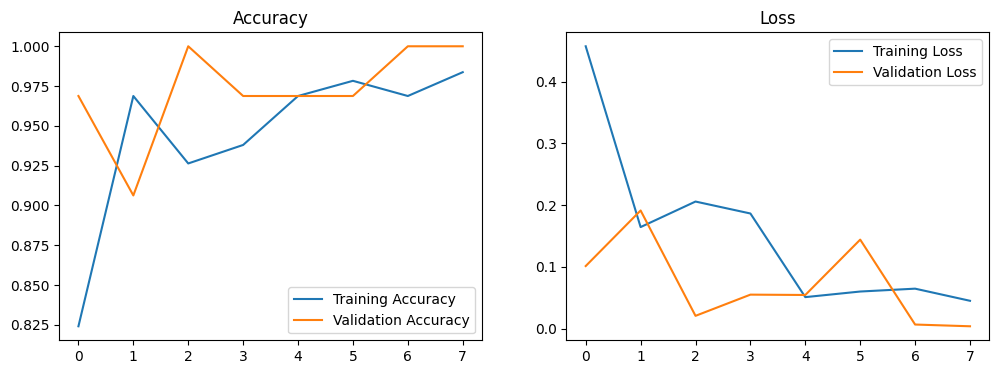

In [19]:
# Block 7: Visualize training results
# Combine histories if needed (for plotting)
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Visualize test results

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step
Visualizing test images with predictions:


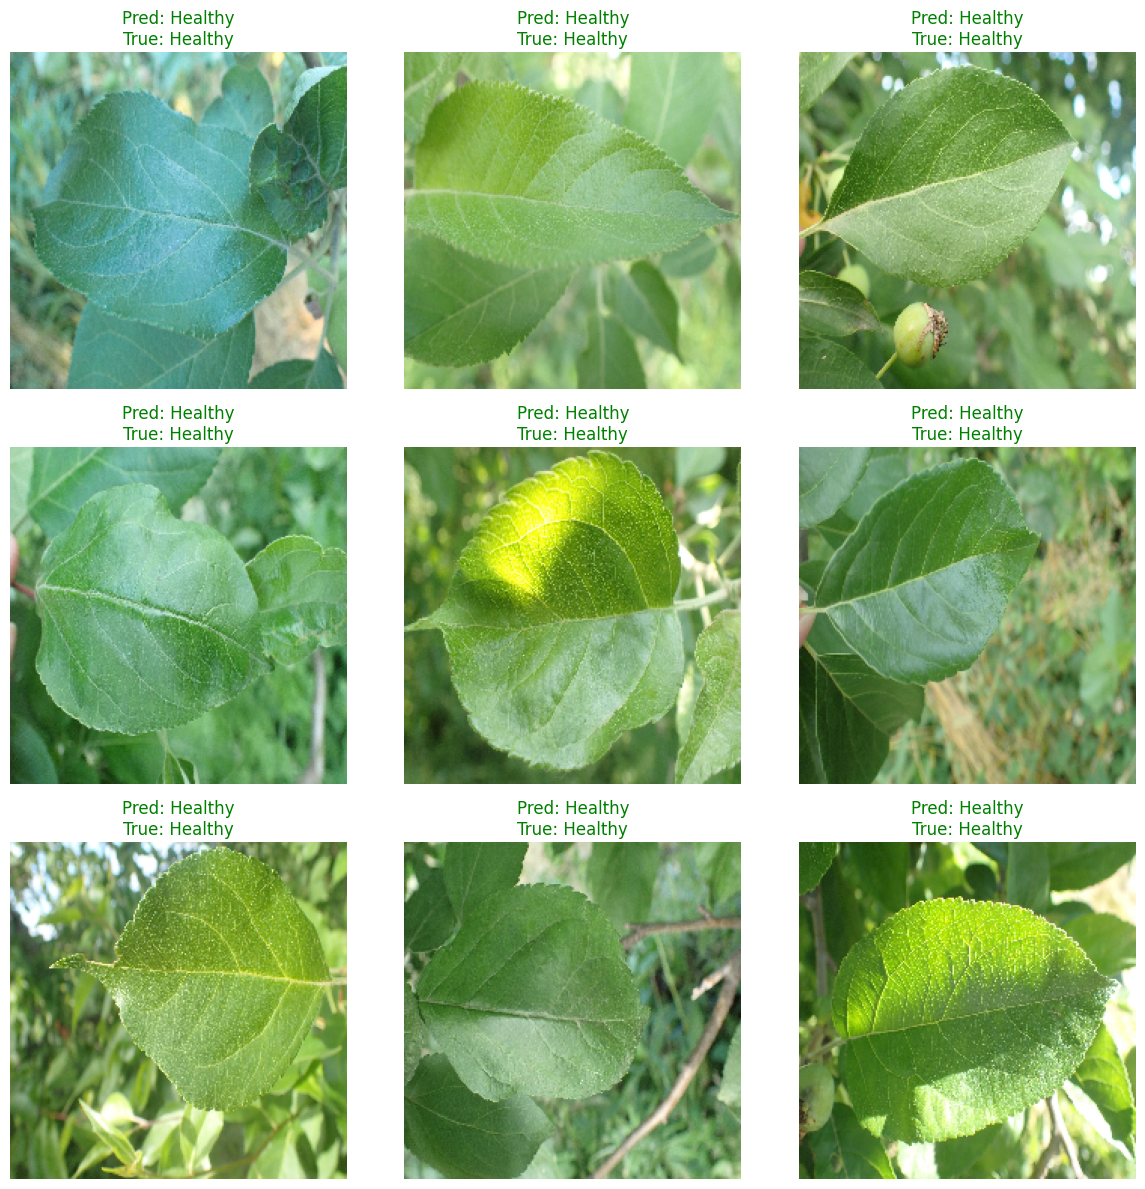

ROC Curves for test data:


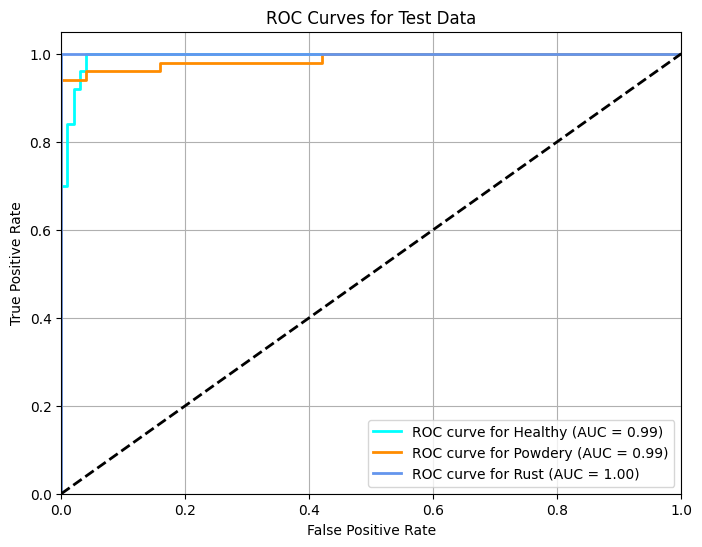

Prediction probability distribution:


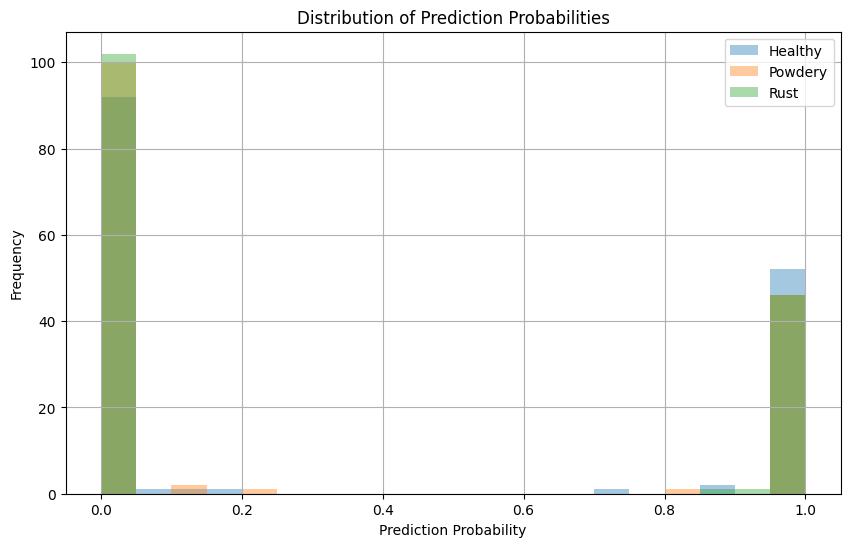

In [20]:
# Block 8: Visualize test results
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Get test predictions and true labels
predictions = model.predict(test_generator)
true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Plot some test images with predictions
def plot_test_images(generator, predictions, class_names, num_images=9):
    images, labels = next(generator)
    pred_classes = np.argmax(predictions[:num_images], axis=1)
    true_classes = np.argmax(labels[:num_images], axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        pred_label = class_names[pred_classes[i]]
        true_label = class_names[true_classes[i]]
        title = f"Pred: {pred_label}\nTrue: {true_label}"
        plt.title(title, color='green' if pred_label == true_label else 'red')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot ROC curves for each class
def plot_roc_curves(true_classes, predictions, class_names):
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

    for i, color in zip(range(len(class_names)), colors):
        fpr, tpr, _ = roc_curve(true_classes == i, predictions[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                label=f'ROC curve for {class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Test Data')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Plot prediction probability distribution
def plot_prediction_distribution(predictions, class_names):
    plt.figure(figsize=(10, 6))
    for i in range(len(class_names)):
        plt.hist(predictions[:, i], bins=20, alpha=0.4, label=class_names[i])
    plt.xlabel('Prediction Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Probabilities')
    plt.legend()
    plt.grid(True)
    plt.show()

# Execute visualizations
print("Visualizing test images with predictions:")
plot_test_images(test_generator, predictions, class_names)

print("ROC Curves for test data:")
plot_roc_curves(true_classes, predictions, class_names)

print("Prediction probability distribution:")
plot_prediction_distribution(predictions, class_names)